In [8]:
import glob
from pathlib import Path

import random
import math

import numpy as np
from numba import njit, prange

import matplotlib.pyplot as plt
from PIL import Image

In [9]:
def load_images(path: Path, thumbnail_shape: tuple) -> list[np.ndarray]:
    fnc1 = np.vectorize(lambda t: 1 if t >= 0.5 else -1)
    files = glob.glob(path.as_posix())
    images = []
    for f in files:
        img = Image.open(f).convert('L')
        img.thumbnail(thumbnail_shape, Image.Resampling.BICUBIC)
        img = np.array(img)
        img = img/np.max(img)
        # img = np.apply_along_axis(fnc1, 0, img)
        images.append(img)
    return images

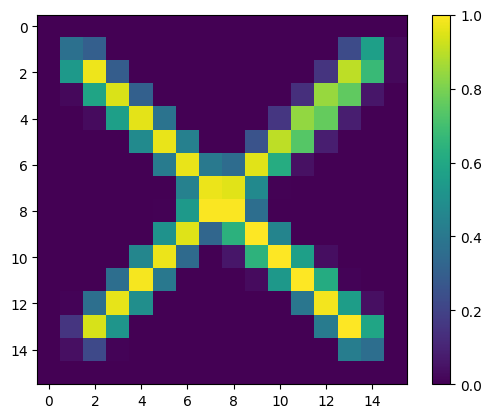

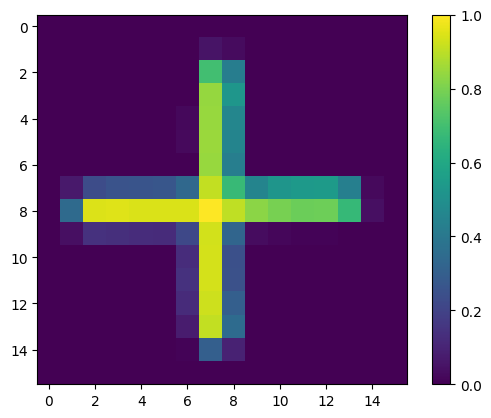

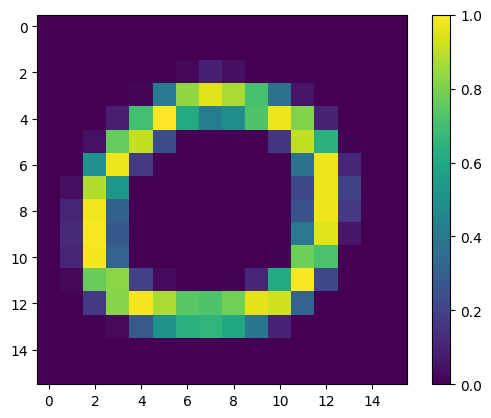

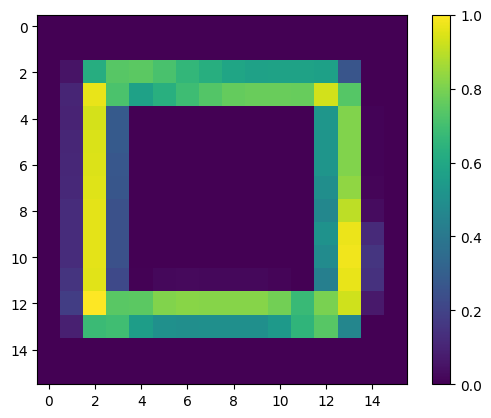

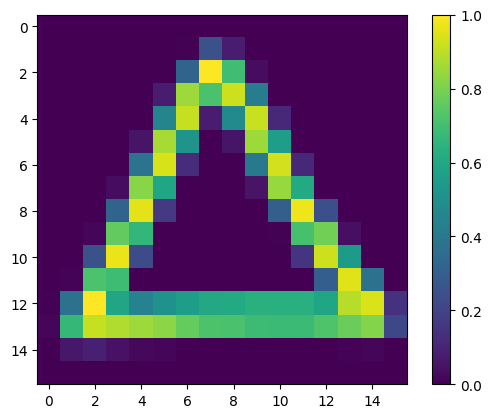

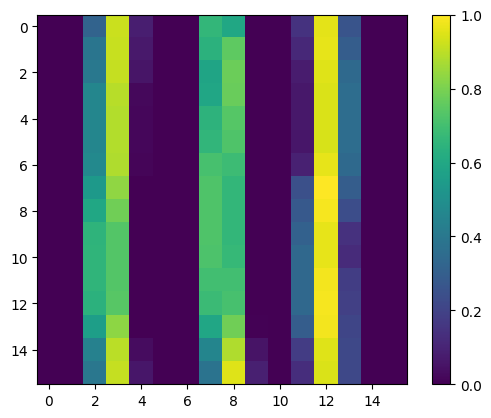

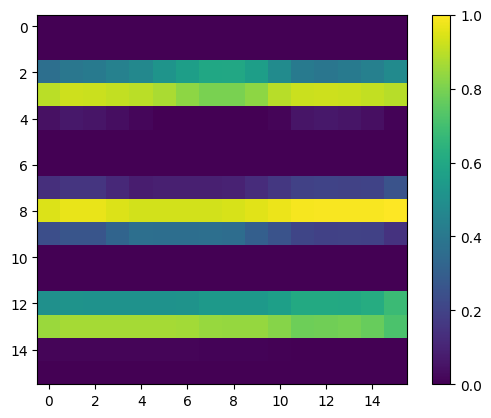

In [10]:
data = load_images(Path('.', 'data', '*'), (16, 16))

for d in data:
    img = plt.imshow(d, cmap='viridis')
    plt.colorbar(img)
    plt.show()

In [11]:
@njit(fastmath=True)
def fit(data: np.ndarray, n: int):
    w = np.zeros((n, n))
    for i in prange(data.shape[0]):
        # w += np.tanh(data[i])*np.tanh(data[i]).reshape((n, 1))
        w += np.tanh(data[i]*data[i].reshape((n, 1)))
        # w += np.exp(-np.square(data[i]))*np.exp(-np.square(data[i])).reshape((n, 1))
        # w += np.exp(-data[i]*data[i].reshape((n, 1)))
        # w += np.exp(-np.square(data[i]*data[i].reshape((n, 1))))
        # w += np.square(data[i]*data[i].reshape((n, 1)))
    return w/n*(1-np.eye(n))


@njit(fastmath=True)
def reconstruct(x: np.ndarray, w: np.ndarray, n: int, niter: int):
    for i in prange(niter):
        idx = random.randint(0, n-1)
        x[idx] = np.dot(w[idx], x)
        # x[idx] = math.tanh(np.dot(w[idx], x))
        # x[idx] = math.exp(-np.dot(w[idx], x))
        # x[idx] = np.dot(w[idx], np.exp(-x))
        # x[idx] = math.exp(-math.pow(np.dot(w[idx], x),2))
    return x


class HopfieldNetwork:
    def __init__(self, n: int) -> None:
        self.n: int = n
        self.memshape: tuple = (n, n)
        self.w: np.ndarray = np.zeros((n, n))

    def learn(self, data: list[np.ndarray]):
        w = fit(np.array([d.flatten() for d in data]), self.n)
        self.w = w

    def reconstruct(self, x: np.ndarray, niter: int):
        return reconstruct(x.flatten(), self.w, self.n, niter)

In [12]:
n = 16*16
memshape = (n, n)

model = HopfieldNetwork(n)
model.learn(data)

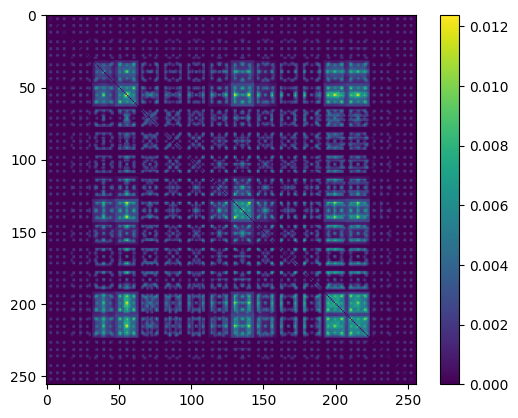

In [13]:
img = plt.imshow(model.w, cmap='viridis')
plt.colorbar(img)
plt.show()

Energy:  -9.449737215739816


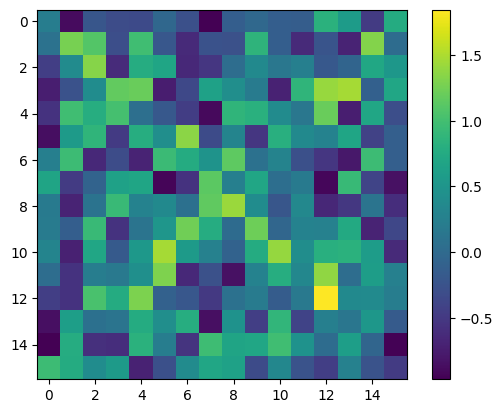

Energy:  -1.7631320881138455e-09


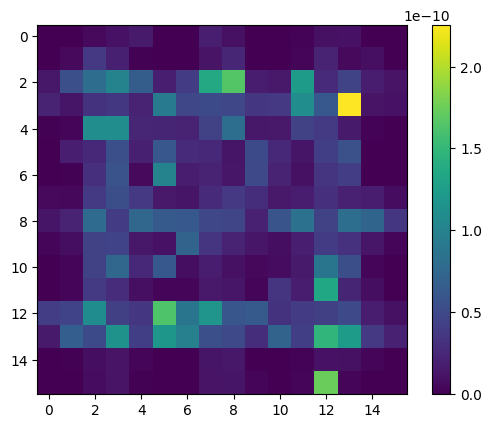

In [14]:
noise_amp = 1
x = data[0]+np.random.uniform(-noise_amp, noise_amp, (16, 16))
y = model.reconstruct(x.flatten(), 10000)

print('Energy: ', -1/2*np.sum(np.dot(model.w, x.flatten())))
img = plt.imshow(x, cmap='viridis')
plt.colorbar(img)
plt.show()

print('Energy: ', -1/2*np.sum(np.dot(model.w, y)))
img = plt.imshow(y.reshape((16, 16)), cmap='viridis')
plt.colorbar(img)
plt.show()